# Epoch-by-epoch Metrics

In [34]:
from config import project_config as config
from utils.sleep_wake_filter import filter_sleep_series
import pandas as pd
import numpy as np
from functools import reduce
from utils.data_utils import read_sleep_dairies_v2

In [35]:
merged_sources_path = 'Results/merged_indicators'
label = 'AWS Sleep'
pred_col_name = 'pred_CNN-Win_3-Freq_10'
models = [pred_col_name, 'Biobank Sleep']
sleep_diaries_path = 'data/Sleep diaries'
diaries_df = read_sleep_dairies_v2(sleep_diaries_path, include_naps=False)

results = pd.DataFrame()
all_preds = pd.DataFrame()
for id in config['subject_ids']:

    subject_diary = diaries_df[diaries_df['subject_id'] == id]

    preds_df = pd.read_csv(f'{merged_sources_path}/sub_{id:02d}.csv')
    preds_df['epoch_ts'] = pd.to_datetime(preds_df['epoch_ts'])
    # df = df.dropna(subset=[label] + models)  # Drop epochs without a label or prediction
    preds_df.insert(0, 'subject_id', id)
    
    # df['pred_AWS-CNN'] = filter_sleep_series(df['pred_AWS-CNN'])
    # df[pred_col_name] = filter_sleep_series(df[pred_col_name])
    
    # Here we mark the epochs between sleep start and sleep end as recorded in sleep diary
    # This is how it's done:
    # - Create a column that's =1 for sleep_start epochs
    # - Create a column that's =-1 for sleep_end epochs
    # - Combine the two column so that the new "lights_off_period" column has a 1 when sleep start and a -1 when it ends
    # - Then find the cumulative sum of the lights_off_period column. The cumsum will be 1 between sleep start and sleep end
    #     and 0 elsewhere
    preds_df['lights_off_time'] = preds_df['epoch_ts'].isin(subject_diary['lights_off']).astype(int)
    preds_df['lights_on_time'] = preds_df['epoch_ts'].isin(subject_diary['lights_on']).astype(int).map({0: 0, 1: -1})  # Mark end of sleep with -1
    
    # merge the two columns. We can simply add them, because they are never non-zero on the same row. i.e. start timestamp and end timestamp are never the same
    preds_df['lights_off_period'] = preds_df['lights_off_time'] + preds_df['lights_on_time']
    preds_df['lights_off_period'] = preds_df['lights_off_period'].cumsum()

    # Next, create a column that assigns a distinct id to each sleep episode
    preds_df['sleep_episode_counter'] = preds_df['lights_off_time'].cumsum()  # This is a helper variable that creates a new id evey time sleep starts
    preds_df['sleep_episode_id'] = preds_df['sleep_episode_counter'].where(preds_df['lights_off_period'] == 1, 0)

    preds_df = preds_df.drop(columns=['lights_off_time', 'lights_on_time', 'sleep_episode_counter'])

    all_preds = pd.concat([all_preds, preds_df])


In [36]:
# Metrics computed over CV epochs only
from sklearn.metrics import classification_report
temp_df = all_preds.copy()
temp_df = all_preds[all_preds['lights_off_period'] == 1]
# temp_df = temp_df.dropna(subset=['PSG Sleep', 'Biobank Sleep'])
temp_df = temp_df.dropna(subset=['AWS Sleep', 'Biobank Sleep', pred_col_name])
temp_df = temp_df[temp_df['is_cv_prediction'] == 1]

print('Models tested on Lab-day PSG labels')
print('*'*60)
print('\nCNN Model')
print(classification_report(y_true=temp_df['PSG Sleep'], y_pred=temp_df[pred_col_name]))
print('-'*60)
print('\nBiobank')
print(classification_report(y_true=temp_df['PSG Sleep'], y_pred=temp_df['Biobank Sleep']))

Models tested on Lab-day PSG labels
************************************************************

CNN Model
              precision    recall  f1-score   support

         0.0       0.50      0.42      0.46      4509
         1.0       0.82      0.86      0.84     13466

    accuracy                           0.75     17975
   macro avg       0.66      0.64      0.65     17975
weighted avg       0.74      0.75      0.74     17975

------------------------------------------------------------

Biobank
              precision    recall  f1-score   support

         0.0       0.61      0.13      0.22      4509
         1.0       0.77      0.97      0.86     13466

    accuracy                           0.76     17975
   macro avg       0.69      0.55      0.54     17975
weighted avg       0.73      0.76      0.70     17975



In [37]:
# from sklearn.metrics import classification_report
# light_off_preds = all_preds[all_preds['lights_off_period'] == 1]
# # temp_df = light_off_preds.dropna(subset=['PSG Sleep', 'Biobank Sleep'])
# temp_df = light_off_preds.dropna(subset=['AWS Sleep', 'Biobank Sleep', 'pred_AWS-CNN'])

# print('AWS Model')
# print(classification_report(y_true=temp_df['AWS Sleep'], y_pred=temp_df['pred_AWS-CNN']))
# print('Biobank')
# print(classification_report(y_true=temp_df['AWS Sleep'], y_pred=temp_df['Biobank Sleep']))

# Sleep Summary Metrics

In [39]:
def calculate_sleep_summary_metrics_v2(preds_df, source_col_name):
    
    # # # 
    # This v2 function calculates SOL and WASO in a different way
    # Instead of looking for a transition to sleep (wake for WASO)
    # It simply takes the first lights_off_period sleep epoch as sleep onset
    # And the first wake epoch after sleep onset as first-wake
    # This probably won't affect WASO, but will certainly change SOL
    # It changes SOL because in many cases the very first epoch of the
    # lights_off_period window is already a sleep epoch and there is no transition
    # inside the lights_off_period window

    # Sleep quality metrics are only calculated during a certain window
    # See cells above where this column was created
    lights_off_fltr = (preds_df['lights_off_period'] == 1)

    # # # # # # # # # # # # # # # # # # # # 
    # #   TRT: Total Recording Time
    # #   Defined as the time in minutes from lights out to
    # #   lights on. This time constitutes the sleep opportunity period.
    # #   Epochs of sleep are only scored between these two points.
    # # # # # # # # # # # # # # # # # # # # 

    TRT_df = preds_df[lights_off_fltr].groupby(['subject_id', 'sleep_episode_id'])['epoch_ts'].count() / 2
    TRT_df = TRT_df.reset_index().rename({'epoch_ts': 'TRT (Min)'}, axis=1)

    # # # # # # # # # # # # # # # # # # # # 
    # #   TST: Total Sleep Time
    # #   Defined as the time in minutes scored as NREM or REM
    # #   but excluding epochs of Unsure and Wake within the period between lights off and lights on
    # # # # # # # # # # # # # # # # # # # # 

    TST_df = preds_df[lights_off_fltr].groupby(['subject_id', 'sleep_episode_id'])[source_col_name].sum() / 2  # each epoch is half a minute
    TST_df = TST_df.reset_index().rename({source_col_name: 'TST (Min)'}, axis=1)

    # # # # # # # # # # # # # # # # # # # # 
    # #   SOL: Sleep Onset Latency
    # #   Defined as the time in minutes occurring from lights off to the first epoch of NREM or REM
    # # # # # # # # # # # # # # # # # # # # 

    lights_off_df = preds_df[lights_off_fltr].groupby(['subject_id', 'sleep_episode_id'])['epoch_ts'].min().\
        reset_index().rename({'epoch_ts': 'lights_off_time'}, axis=1)  # timestamp of the first lights_off_period epoch

    asleep_fltr = (preds_df[source_col_name] == 1)
    sleep_onset_df = preds_df[lights_off_fltr & asleep_fltr].groupby(['subject_id', 'sleep_episode_id'])['epoch_ts'].min().\
        reset_index().rename({'epoch_ts': 'sleep_onset'}, axis=1)  # timestamp of the first lights_off_period sleep epoch

    SOL_df = pd.merge(
        left=lights_off_df,
        right=sleep_onset_df,
        on=['subject_id', 'sleep_episode_id'],
        how='left'
    )
    SOL_df['SOL (Min)'] = (SOL_df['sleep_onset'] - SOL_df['lights_off_time']).dt.seconds / 60  # convert to minutes
    SOL_df = SOL_df.drop(['lights_off_time'], axis=1)  # keep sleep_onset for WASO

    # # # # # # # # # # # # # # # # # # # # 
    # #   WASO: Wake After Sleep Onset
    # #   Defined as the time in minutes of epochs scored as wake from SOL until lights on
    # # # # # # # # # # # # # # # # # # # # 

    # We need to find first wake after sleep onset. Let's first remove epochs before sleep onset
    first_wake_df = pd.merge(  # bringing in sleep onset (binary indicator) column
        left=preds_df[lights_off_fltr],
        right=SOL_df.drop('SOL (Min)', axis=1),  # don't need this column
        on=['subject_id', 'sleep_episode_id'],
        how='left'
    )
    # Sleep onset column is specific to each subject and sleep episode
    # So, we don't need to worry about grouping or filtering by these here
    # This is a row-wise comparison
    after_sleep_onset_df = first_wake_df[first_wake_df['epoch_ts'] > first_wake_df['sleep_onset']]  # remove epochs that occur before sleep onset
    awake_fltr = (after_sleep_onset_df[source_col_name] == 0)
    WASO_df = after_sleep_onset_df[awake_fltr].groupby(['subject_id', 'sleep_episode_id'])['epoch_ts'].count() / 2  # 2 epochs = 1 minutes
    WASO_df = WASO_df.reset_index().rename({'epoch_ts': 'WASO (Min)'}, axis=1)

    # bring in sleep onset timestamp to calculate time between sleep onset and first wake
    # WASO_df = pd.merge(
    #     left=first_wake_df,
    #     right=sleep_onset_df,
    #     on=['subject_id', 'sleep_episode_id'],
    #     how='left'
    # )

    # WASO_df['WASO (Min)'] = (WASO_df['first_wake'] - WASO_df['sleep_onset']).dt.seconds / 60  # convert to mintues
    # WASO_df = WASO_df.drop(['first_wake', 'sleep_onset'], axis=1)

    # Now that we're done with WASO we can drop sleep_onset from SOL
    SOL_df = SOL_df.drop('sleep_onset', axis=1)

    # # # # # # # # # # # # # # # # # # # # 
    # #   SEEF: Sleep Efficiency
    # #   Defined as the percentage of TST against TRT
    # # # # # # # # # # # # # # # # # # # # 

    SEEF_df = pd.merge(
        left=TRT_df,
        right=TST_df,
        on=['subject_id', 'sleep_episode_id'],
        how='left'
    )

    SEEF_df['SEEF'] = SEEF_df['TST (Min)'] / SEEF_df['TRT (Min)']
    SEEF_df = SEEF_df.drop(['TRT (Min)', 'TST (Min)'], axis=1)
    
    metrics_list = [TRT_df, TST_df, SEEF_df, SOL_df, WASO_df]

    merge_fn = lambda l, r: pd.merge(
        left=l,
        right=r,
        on=['subject_id', 'sleep_episode_id'],
        how='left'
    )

    sleep_summary_metrics = reduce(merge_fn, metrics_list)

    return sleep_summary_metrics

In [40]:
# Load participation dates to find the lab-day
# The lab-day is the last day for all subjects
# So we can find the time that lab day starts by subtracting 1 Day (exactly 24 hours)
# from their end timestamp

# We need to remove lab day from metric calculations (at least for now)
# Becuase we don't have proper predictions for lab day (used for training)
# there are rare cases where a few epochs were not in training and so they appear in the test set
# And not removing them could bias our metric values
# So, I explicitly remove the entire lab day before calculating sleep summary metrics

participation_dates = pd.read_csv('data/participation_dates.csv')

for dt_col in ['start_timestamp', 'end_timestamp']:
    participation_dates[dt_col] = pd.to_datetime(participation_dates[dt_col])

participation_dates['lab_day_start'] = pd.to_datetime(participation_dates['end_timestamp'])
participation_dates['lab_day_start'] = participation_dates['end_timestamp'] - np.timedelta64(1, 'D')
participation_dates = participation_dates[['subject_id', 'start_timestamp', 'lab_day_start']]

# Remove epochs after the timestamp that marks the start of the lab day
# See comment above
preds_df = pd.merge(
    left=all_preds,
    right=participation_dates,
    on='subject_id',
    how='left'
)
valid_data_fltr = (preds_df['epoch_ts'].between(preds_df['start_timestamp'], preds_df['lab_day_start'], inclusive='left'))
preds_df = preds_df[valid_data_fltr].drop('lab_day_start', axis=1)

# Now calculating the metrics
source_cols = [pred_col_name, 'Biobank Sleep', 'AWS Sleep']
metrics_df = pd.DataFrame()
for source in source_cols:
    # source_metrics_df = calculate_sleep_summary_metrics(preds_df, source_col_name=source)
    source_metrics_df = calculate_sleep_summary_metrics_v2(preds_df, source_col_name=source)
    # for col in [c for c in source_metrics_df.columns if c not in ['subject_id', 'sleep_episode_id']]:
    #     source_metrics_df = source_metrics_df.rename({col: col + f'-{source}'}, axis=1)
    source_metrics_df.insert(0, 'source', source)
    metrics_df = pd.concat([metrics_df, source_metrics_df])

metrics_df.to_excel('sleep_metrics.xlsx', index=False)

In [42]:
metrics_df.drop(['subject_id', 'sleep_episode_id'], axis=1).groupby('source').agg(['mean', 'std']).round(2)

TRT (Min)        TST (Min)          SEEF        \
                            mean    std      mean     std  mean   std   
source                                                                  
AWS Sleep                 444.49  88.17    375.29   98.09  0.85  0.16   
Biobank Sleep             444.49  88.17    379.89  134.03  0.85  0.25   
pred_CNN-Win_3-Freq_10    444.49  88.17    334.54  116.90  0.75  0.22   

                       SOL (Min)        WASO (Min)         
                            mean    std       mean    std  
source                                                     
AWS Sleep                   3.90   7.75      52.38  32.89  
Biobank Sleep               7.94  14.52      23.14  23.99  
pred_CNN-Win_3-Freq_10      6.13  12.15      80.11  44.76

In [43]:
# # preds_df.groupby('sleep_episode_id')['Biobank Sleep'].transform(lambda x: x.isna().sum())
# temp = preds_df[preds_df['sleep_episode_id'] > 0].copy()
# temp['biobank_nan'] = temp['Biobank Sleep'].isna()
# temp['episode_has_nan'] = temp.groupby(['subject_id', 'sleep_episode_id'])['biobank_nan'].transform('sum').gt(0)

In [44]:
# temp = temp[~temp['episode_has_nan']]

# # Now calculating the metrics
# source_cols = [pred_col_name, 'Biobank Sleep', 'AWS Sleep']
# metrics_df = pd.DataFrame()
# for source in source_cols:
#     source_metrics_df = calculate_sleep_summary_metrics(temp, source_col_name=source)
#     source_metrics_df.insert(0, 'source', source)
#     metrics_df = pd.concat([metrics_df, source_metrics_df])

## Agreement metrics

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by 'source' to calculate the mean and std for each sleep metric
grouped_df = metrics_df.groupby('source').agg({
    'TST (Min)': ['mean', 'std'],
    'SOL (Min)': ['mean', 'std'],
    'WASO (Min)': ['mean', 'std'],
    'SEEF': ['mean', 'std']
}).reset_index()

# Rename columns for easier access
grouped_df.columns = ['source', 'TST_mean', 'TST_std', 'SOL_mean', 'SOL_std', 'WASO_mean', 'WASO_std', 'SEFF_mean', 'SEFF_std']

# Create dictionaries to hold the data for each source
aws_sleep = {}
biobank_sleep = {}
pred_psg_cnn = {}

# Fill the dictionaries with data from the dataframe
for index, row in grouped_df.iterrows():
    if row['source'] == 'AWS Sleep':
        aws_sleep = {
            'TST': [round(row['TST_mean'], 2), round(row['TST_std'], 2)],
            'SOL': [round(row['SOL_mean'], 2), round(row['SOL_std'], 2)],
            'WASO': [round(row['WASO_mean'], 2), round(row['WASO_std'], 2)],
            'SEFF': [round(row['SEFF_mean'], 2), round(row['SEFF_std'], 2)]
        }
    elif row['source'] == 'Biobank Sleep':
        biobank_sleep = {
            'TST': [round(row['TST_mean'], 2), round(row['TST_std'], 2)],
            'SOL': [round(row['SOL_mean'], 2), round(row['SOL_std'], 2)],
            'WASO': [round(row['WASO_mean'], 2), round(row['WASO_std'], 2)],
            'SEFF': [round(row['SEFF_mean'], 2), round(row['SEFF_std'], 2)]
        }
    elif row['source'] == pred_col_name:
        pred_psg_cnn = {
            'TST': [round(row['TST_mean'], 2), round(row['TST_std'], 2)],
            'SOL': [round(row['SOL_mean'], 2), round(row['SOL_std'], 2)],
            'WASO': [round(row['WASO_mean'], 2), round(row['WASO_std'], 2)],
            'SEFF': [round(row['SEFF_mean'], 2), round(row['SEFF_std'], 2)]
        }

# Extracting means and std for each metric
aws_mean_std = pd.DataFrame(aws_sleep, index=['mean', 'std']).T
biobank_mean_std = pd.DataFrame(biobank_sleep, index=['mean', 'std']).T
pred_psg_mean_std = pd.DataFrame(pred_psg_cnn, index=['mean', 'std']).T

# Bland-Altman plots

In [47]:
# Define the corrected Bland-Altman plot function
def bland_altman_plot_corrected(data1, data2, metric, method1, method2, ax):
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)
    
    ax.scatter(mean, diff, alpha=0.5, color='red')
    ax.axhline(md, color='purple', linestyle='-')
    ax.axhline(md + 1.96 * sd, color='purple', linestyle='--')
    ax.axhline(md - 1.96 * sd, color='purple', linestyle='--')
    ax.set_xlabel(f'Average {metric} (min)')
    ax.set_ylabel(f'{method1}-{method2} {metric} (min)')

Count of each unique value:
     source_aws  subject_id  sleep_episode_id  TRT (Min)_aws  TST (Min)_aws  \
0    AWS Sleep           1                 4          450.0          422.0   
1    AWS Sleep           1                 7          467.0          432.0   
2    AWS Sleep           2                 6          480.0          450.0   
3    AWS Sleep           3                 1          560.0          490.0   
4    AWS Sleep           3                 2          570.0          468.0   
..         ...         ...               ...            ...            ...   
240  AWS Sleep          36                 7          485.0          344.0   
241  AWS Sleep          36                 8          455.0          353.0   
242  AWS Sleep          36                 9          470.0          414.0   
243  AWS Sleep          36                11          527.0          390.0   
244  AWS Sleep          36                12          512.0          389.0   

     SEEF_aws  SOL (Min)_aws  WASO

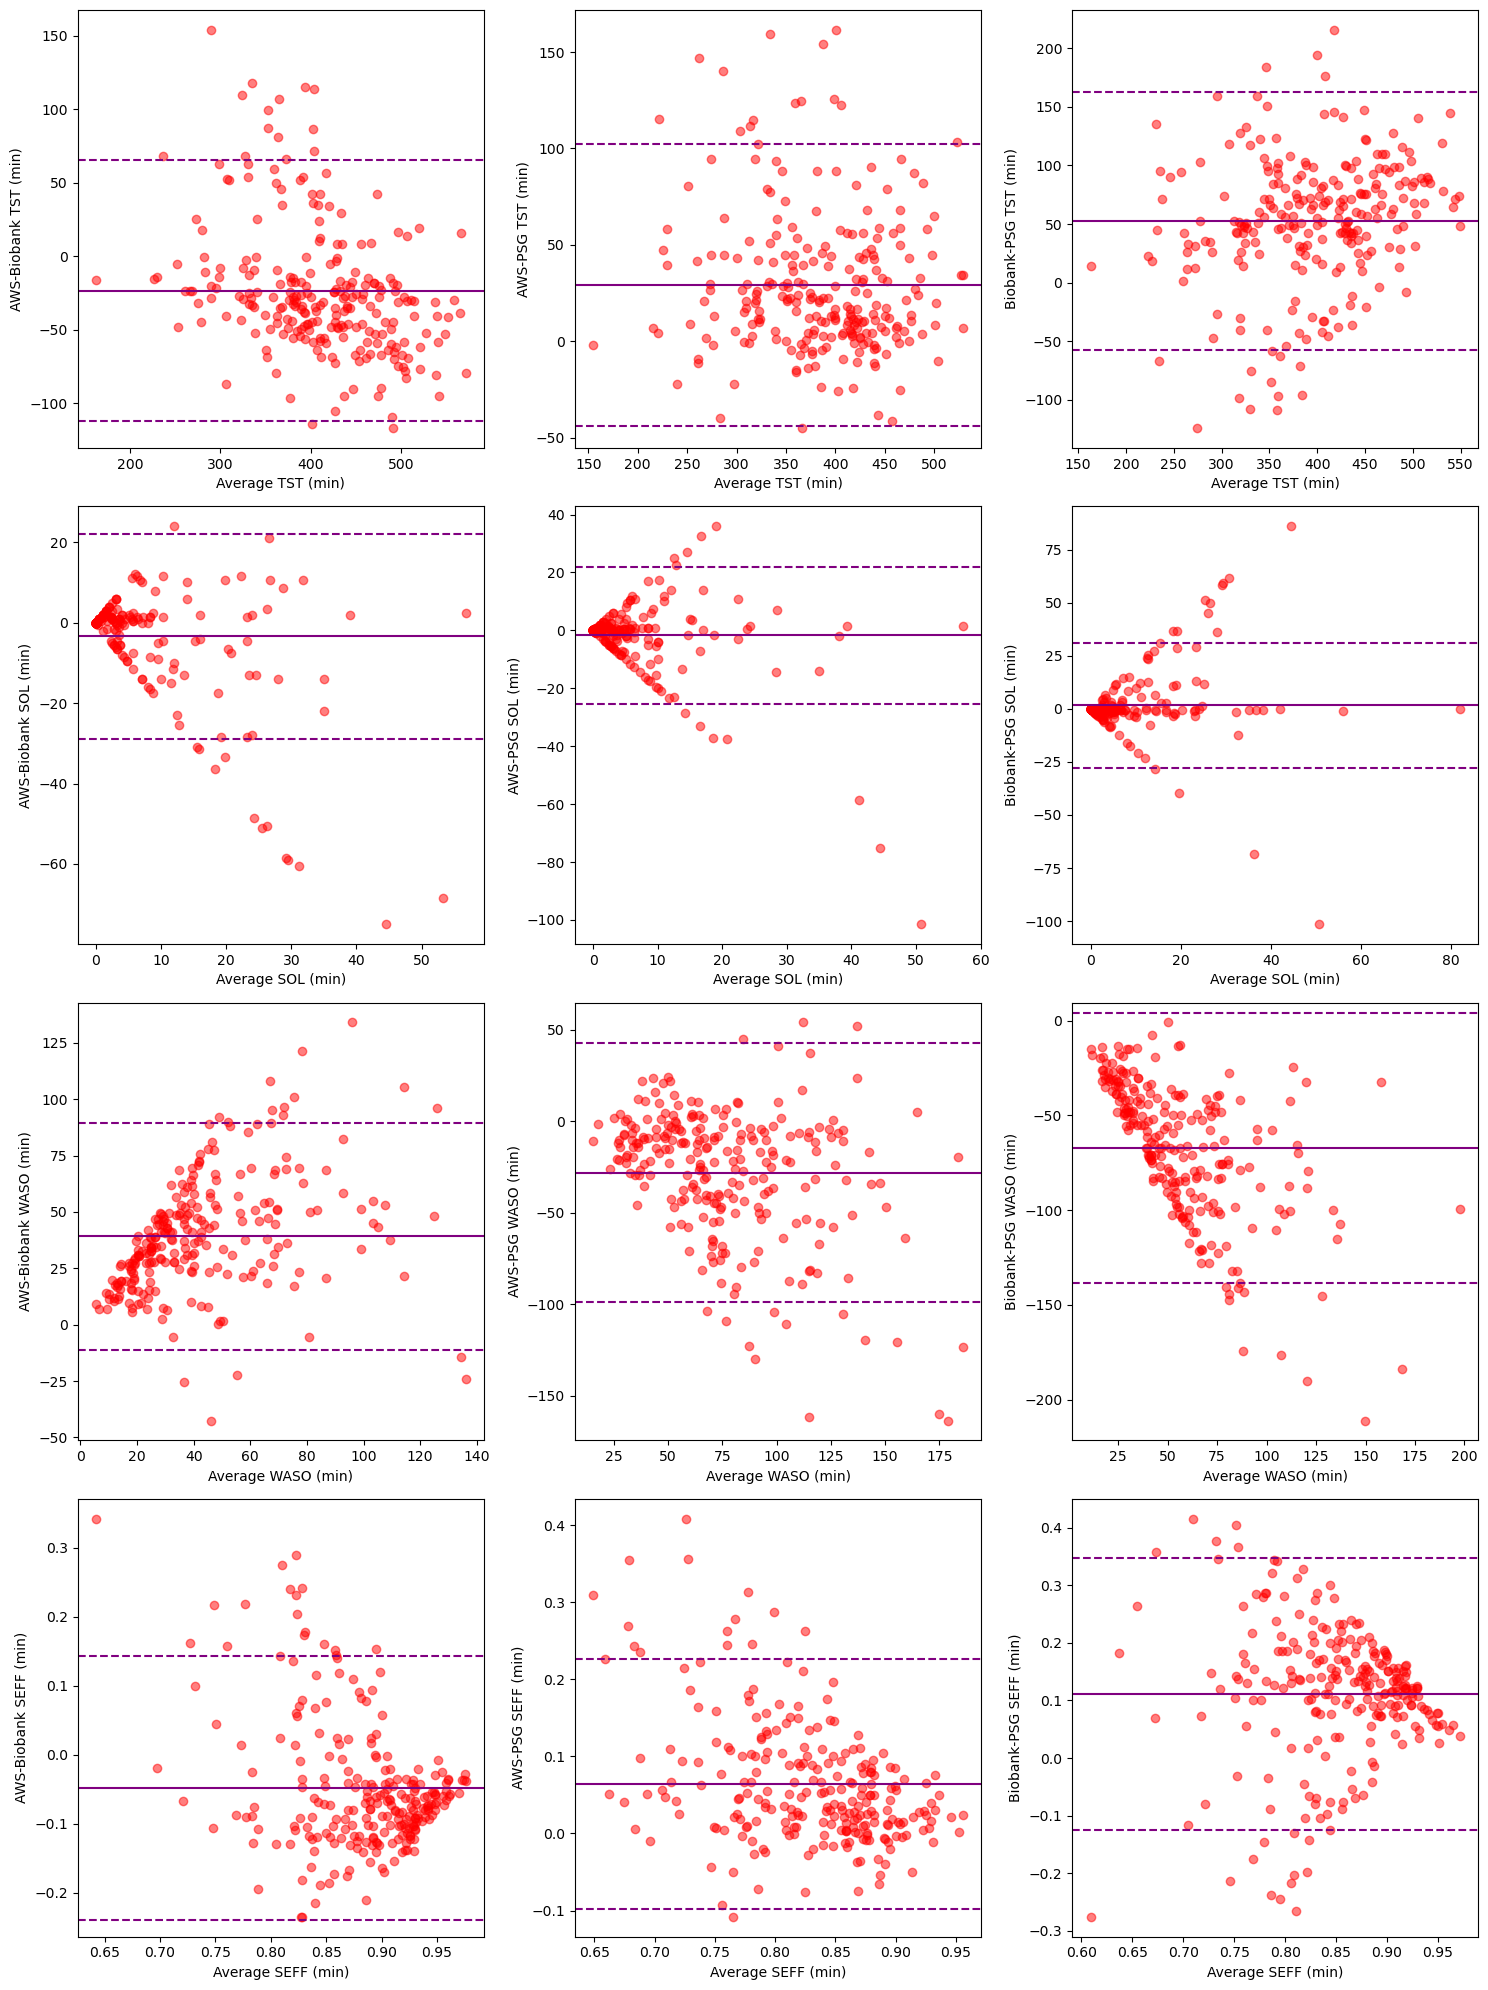

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Extract the different sources
aws = metrics_df[metrics_df['source'] == 'AWS Sleep']
biobank = metrics_df[metrics_df['source'] == 'Biobank Sleep']
pred_psg = metrics_df[metrics_df['source'] == pred_col_name]

# Define the metrics and their titles
metrics = ['TST (Min)', 'SOL (Min)', 'WASO (Min)', 'SEEF']
titles = ['TST', 'SOL', 'WASO', 'SEFF']

# Dropping rows with NaN values in any of the metrics
aws_filtered = aws.dropna(subset=metrics)
biobank_filtered = biobank.dropna(subset=metrics)
pred_psg_filtered = pred_psg.dropna(subset=metrics)

# Ensure that the data pairs are perfectly aligned by subject_id and sleep_episode_id
merged_df = pd.merge(aws_filtered, biobank_filtered, on=['subject_id', 'sleep_episode_id'], suffixes=('_aws', '_biobank'))
merged_df = pd.merge(merged_df, pred_psg_filtered, on=['subject_id', 'sleep_episode_id'])

print("Count of each unique value:\n", merged_df)

# Proceeding to plot with the merged and perfectly aligned data
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# Plot Bland-Altman plots for each metric with the filtered and aligned data
for i, metric in enumerate(metrics):
    bland_altman_plot_corrected(merged_df[f'{metric}_aws'], merged_df[f'{metric}_biobank'], titles[i], 'AWS', 'Biobank', axs[i, 0])
    bland_altman_plot_corrected(merged_df[f'{metric}_aws'], merged_df[metric], titles[i], 'AWS', 'PSG', axs[i, 1])
    bland_altman_plot_corrected(merged_df[f'{metric}_biobank'], merged_df[metric], titles[i], 'Biobank', 'PSG', axs[i, 2])

plt.tight_layout()
plt.show()


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by 'source' to calculate the mean and std for each sleep metric
grouped_df = metrics_df.groupby('source').agg({
    'TST (Min)': ['mean', 'std'],
    'SOL (Min)': ['mean', 'std'],
    'WASO (Min)': ['mean', 'std'],
    'SEEF': ['mean', 'std']
}).reset_index()

# Rename columns for easier access
grouped_df.columns = ['source', 'TST_mean', 'TST_std', 'SOL_mean', 'SOL_std', 'WASO_mean', 'WASO_std', 'SEFF_mean', 'SEFF_std']

# Create dictionaries to hold the data for each source
aws_sleep = {}
biobank_sleep = {}
pred_psg_cnn = {}

# Fill the dictionaries with data from the dataframe
for index, row in grouped_df.iterrows():
    if row['source'] == 'AWS Sleep':
        aws_sleep = {
            'TST': [round(row['TST_mean'], 2), round(row['TST_std'], 2)],
            'SOL': [round(row['SOL_mean'], 2), round(row['SOL_std'], 2)],
            'WASO': [round(row['WASO_mean'], 2), round(row['WASO_std'], 2)],
            'SEFF': [round(row['SEFF_mean'], 2), round(row['SEFF_std'], 2)]
        }
    elif row['source'] == 'Biobank Sleep':
        biobank_sleep = {
            'TST': [round(row['TST_mean'], 2), round(row['TST_std'], 2)],
            'SOL': [round(row['SOL_mean'], 2), round(row['SOL_std'], 2)],
            'WASO': [round(row['WASO_mean'], 2), round(row['WASO_std'], 2)],
            'SEFF': [round(row['SEFF_mean'], 2), round(row['SEFF_std'], 2)]
        }
    elif row['source'] == pred_col_name:
        pred_psg_cnn = {
            'TST': [round(row['TST_mean'], 2), round(row['TST_std'], 2)],
            'SOL': [round(row['SOL_mean'], 2), round(row['SOL_std'], 2)],
            'WASO': [round(row['WASO_mean'], 2), round(row['WASO_std'], 2)],
            'SEFF': [round(row['SEFF_mean'], 2), round(row['SEFF_std'], 2)]
        }

# Extracting means and std for each metric
aws_mean_std = pd.DataFrame(aws_sleep, index=['mean', 'std']).T
biobank_mean_std = pd.DataFrame(biobank_sleep, index=['mean', 'std']).T
pred_psg_mean_std = pd.DataFrame(pred_psg_cnn, index=['mean', 'std']).T

In [ ]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan


def calculate_metrics_single(method1_mean, method1_std, method2_mean, method2_std):
    # Calculate differences
    diff = method1_mean - method2_mean
    
    # # # # # # # # # # # # # # # # # # # # 
    # #   Bias
    # # # # # # # # # # # # # # # # # # # # 
    bias = diff
    
    
    # # # # # # # # # # # # # # # # # # # # 
    # #   Bias Confidence Interval
    # # # # # # # # # # # # # # # # # # # # 
    se_bias = method1_std  # Standard error of mean for one observation
    ci_bias = se_bias * stats.t.ppf((1 + 0.95) / 2., 1)
    bias_ci = (bias - ci_bias, bias + ci_bias)

    
    
    # # # # # # # # # # # # # # # # # # # # 
    # #  Limits of Agreement (LoA)
    # # # # # # # # # # # # # # # # # # # # 
    mean_diff = diff
    std_diff = method1_std
    loa_lower = mean_diff - 1.96 * std_diff
    loa_upper = mean_diff + 1.96 * std_diff

    
    # # # # # # # # # # # # # # # # # # # # 
    # #  LoA Confidence Intervals
    # # # # # # # # # # # # # # # # # # # # 
    se_loa = std_diff
    ci_loa = se_loa * stats.t.ppf((1 + 0.95) / 2., 1)
    loa_lower_ci = (loa_lower - ci_loa, loa_lower + ci_loa)
    loa_upper_ci = (loa_upper - ci_loa, loa_upper + ci_loa)
    
    
    
    # # # # # # # # # # # # # # # # # # # # 
    # #  Minimal Detectable Change (MDC)
    # # # # # # # # # # # # # # # # # # # # 
    mdc = (loa_upper - loa_lower) / 2

    
    # # # # # # # # # # # # # # # # # # # # 
    # #  Standardized Absolute Difference (SAD) 
    # # # # # # # # # # # # # # # # # # # # 
    mean1 = method1_mean
    mean2 = method2_mean
    var1 = method1_std**2
    var2 = method2_std**2
    n = 2  # assuming we have two samples

    mean_diff = np.abs(mean1 - mean2)
    pooled_std = np.sqrt(((n - 1) * (var1 + var2)) / (2 * n - 2))
    sad = mean_diff / pooled_std

    # SAD Confidence Interval
    se_sad = pooled_std
    ci_sad = se_sad * stats.t.ppf((1 + 0.95) / 2., 1)
    sad_ci = (sad - ci_sad, sad + ci_sad)
    
    
    
    # # # # # # # # # # # # # # # # # # # # 
    # #  Symmetric Mean Absolute Percentage Error (SMAPE)
    # # # # # # # # # # # # # # # # # # # #  
    smape = (1 / n) * np.sum(np.abs(diff) / (np.abs(method1_mean) + np.abs(method2_mean))) * 100
    # Standard Error of SMAPE
    se_smape = np.std([np.abs(diff) / (np.abs(method1_mean) + np.abs(method2_mean))]) * 100 if n > 1 else smape * 0.1
    # 95% Confidence Interval for SMAPE
    ci_smape = se_smape * stats.t.ppf((1 + 0.95) / 2., 1) if se_smape > 0 else smape * 0.1
    smape_ci = (smape - ci_smape, smape + ci_smape)
    
    
    
    # # # # # # # # # # # # # # # # # # # # 
    # #  Intraclass Correlation Coefficient (ICC)
    # #  Simplified ICC calculation for single pair of means and stds
    # # # # # # # # # # # # # # # # # # # # 
    icc = (var1 - var2) / (var1 + var2)

    # ICC Confidence Interval
    se_icc = (1 - icc**2)
    ci_icc = se_icc * stats.t.ppf((1 + 0.95) / 2., 1)
    icc_ci = (icc - ci_icc, icc + ci_icc)
    
    
    
    # # # # # # # # # # # # # # # # # # # # 
    # #  Proportional Bias
    # # # # # # # # # # # # # # # # # # # #  
    X = np.array([method1_mean, method2_mean]).reshape(-1, 1)
    y = np.array([diff, diff])  # Use diff array with two identical values
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print('='*40)
    print(X)
    print('-'*40)
    print(y)
    print(model.pvalues)
    print('='*40)
    proportional_bias = model.pvalues[1] < 0.05


    # # # # # # # # # # # # # # # # # # # # 
    # #  Heteroscedasticity
    # # # # # # # # # # # # # # # # # # # #  
    test = het_breuschpagan(model.resid, model.model.exog)
    heteroscedasticity = test[1] < 0.05

    
    # # # # # # # # # # # # # # # # # # # # 
    # #   Log-transform applicable
    # # # # # # # # # # # # # # # # # # # #  
    skewness = stats.skew([method1_mean, method2_mean])
    kurtosis = stats.kurtosis([method1_mean, method2_mean])
    log_transform_applicable = np.abs(skewness) > 1 or np.abs(kurtosis) > 1
    
    

    return {
        'Bias': round(bias, 2),
        'Bias_CI': [round(bias_ci[0], 2), round(bias_ci[1], 2)],
        'LoA_Lower': round(loa_lower, 2),
        'LoA_Lower_CI': [round(loa_lower_ci[0], 2),round(loa_lower_ci[1], 2) ],
        'LoA_Upper': round(loa_upper, 2),
        'LoA_Upper_CI': [round(loa_upper_ci[0], 2), round(loa_upper_ci[1], 2)],
        'MDC': round(mdc, 2),
        'SAD': round(sad, 2),
        'SAD_CI': [round(sad_ci[0], 2), round(sad_ci[1], 2)],
        'SMAPE': round(smape, 2),
        'SMAPE_CI': [round(smape_ci[0], 5),round(smape_ci[1], 5) ],
        'ICC': round(icc, 2),
        'ICC_CI': [round(icc_ci[0], 2),round(icc_ci[1], 2)],
        'Proportional_Bias': proportional_bias,
        'Heteroscedasticity': heteroscedasticity,
        'Log_Transform_Applicable': log_transform_applicable
    }

In [81]:
# aws vs biobank

In [82]:
aws_mean_std.loc['WASO', 'mean']

52.38

In [83]:
# Calculate metrics for each comparison
# metrics_tst = calculate_metrics_single(aws_mean_std.loc['TST', 'mean'], aws_mean_std.loc['TST', 'std'],
#                                        biobank_mean_std.loc['TST', 'mean'], biobank_mean_std.loc['TST', 'std'])

# metrics_sol = calculate_metrics_single(aws_mean_std.loc['SOL', 'mean'], aws_mean_std.loc['SOL', 'std'],
#                                        biobank_mean_std.loc['SOL', 'mean'], biobank_mean_std.loc['SOL', 'std'])

metrics_waso = calculate_metrics_single(aws_mean_std.loc['WASO', 'mean'], aws_mean_std.loc['WASO', 'std'],
                                        biobank_mean_std.loc['WASO', 'mean'], biobank_mean_std.loc['WASO', 'std'])

metrics_seff = calculate_metrics_single(aws_mean_std.loc['SEFF', 'mean'], aws_mean_std.loc['SEFF', 'std'],
                                        biobank_mean_std.loc['SEFF', 'mean'], biobank_mean_std.loc['SEFF', 'std'])

metrics_tst, metrics_sol, metrics_waso, metrics_seff

[[52.38]
 [23.14]]
[[ 1.   52.38]
 [ 1.   23.14]]
[[ 1.   52.38]
 [ 1.   23.14]]
----------------------------------------
[29.24 29.24]
[nan nan]
[[0.85]
 [0.85]]
[[0.85]
 [0.85]]
[[0.85]
 [0.85]]
----------------------------------------
[0. 0.]
[nan]


/opt/miniconda3/envs/sleep/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
'# aws vs pred_psg'

In [ ]:
# Calculate metrics for each comparison
metrics_tst = calculate_metrics_single(aws_mean_std.loc['TST', 'mean'], aws_mean_std.loc['TST', 'std'],
                                       pred_psg_mean_std.loc['TST', 'mean'], pred_psg_mean_std.loc['TST', 'std'])

metrics_sol = calculate_metrics_single(aws_mean_std.loc['SOL', 'mean'], aws_mean_std.loc['SOL', 'std'],
                                       pred_psg_mean_std.loc['SOL', 'mean'], pred_psg_mean_std.loc['SOL', 'std'])

metrics_waso = calculate_metrics_single(aws_mean_std.loc['WASO', 'mean'], aws_mean_std.loc['WASO', 'std'],
                                        pred_psg_mean_std.loc['WASO', 'mean'], pred_psg_mean_std.loc['WASO', 'std'])

metrics_seff = calculate_metrics_single(aws_mean_std.loc['SEFF', 'mean'], aws_mean_std.loc['SEFF', 'std'],
                                        pred_psg_mean_std.loc['SEFF', 'mean'], pred_psg_mean_std.loc['SEFF', 'std'])

metrics_tst, metrics_sol, metrics_waso, metrics_seff

In [ ]:
# biobank vs pred_psg

In [ ]:
# Calculate metrics for each comparison
metrics_tst = calculate_metrics_single(biobank_mean_std.loc['TST', 'mean'], biobank_mean_std.loc['TST', 'std'],
                                       pred_psg_mean_std.loc['TST', 'mean'], pred_psg_mean_std.loc['TST', 'std'])

metrics_sol = calculate_metrics_single(biobank_mean_std.loc['SOL', 'mean'], biobank_mean_std.loc['SOL', 'std'],
                                       pred_psg_mean_std.loc['SOL', 'mean'], pred_psg_mean_std.loc['SOL', 'std'])

metrics_waso = calculate_metrics_single(biobank_mean_std.loc['WASO', 'mean'], biobank_mean_std.loc['WASO', 'std'],
                                        pred_psg_mean_std.loc['WASO', 'mean'], pred_psg_mean_std.loc['WASO', 'std'])

metrics_seff = calculate_metrics_single(biobank_mean_std.loc['SEFF', 'mean'], biobank_mean_std.loc['SEFF', 'std'],
                                        pred_psg_mean_std.loc['SEFF', 'mean'], pred_psg_mean_std.loc['SEFF', 'std'])

metrics_tst, metrics_sol, metrics_waso, metrics_seff

## Plots

/var/folders/5m/znlstgm107v6b4cw5_hs0dgc0000gp/T/ipykernel_76436/97027901.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diary_tst['sleep_episode_key'] = diary['subject_id'].astype(str) + '_' + diary['lights_off'].dt.date.astype(str)


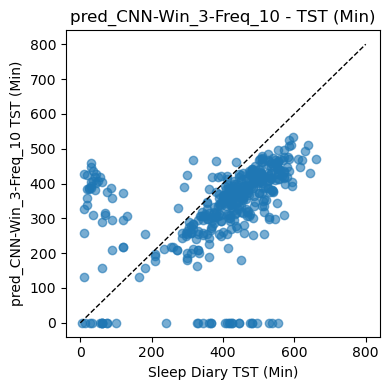

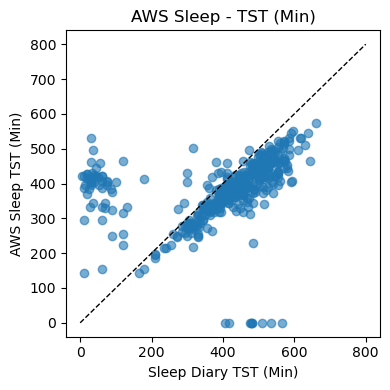

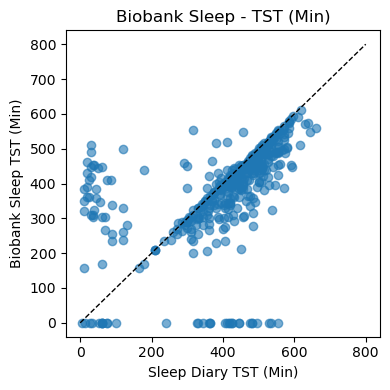

In [53]:
# Plots

diary = read_sleep_dairies_v2('data/Sleep diaries', include_naps=True)

import matplotlib.pyplot as plt

# Load the datasets
metric_df = metrics_df

# Convert lights_off and lights_on to datetime
diary['lights_off'] = pd.to_datetime(diary['lights_off'])
diary['lights_on'] = pd.to_datetime(diary['lights_on'])

def calculate_diary_tst(diary_df):
    # TST: Total Sleep Time
    diary_df['TST (Min)'] = (diary_df['lights_on'] - diary_df['lights_off']).dt.total_seconds() / 60
    return diary_df[['subject_id', 'lights_off', 'TST (Min)']]

# Calculate TST for the diary data
diary_tst = calculate_diary_tst(diary)

# Extract the start date for each subject from the diary data
start_dates = diary.groupby('subject_id')['lights_off'].min().reset_index()
start_dates.rename(columns={'lights_off': 'start_date'}, inplace=True)

# Merge start_dates with metric_df to get the start date for each subject
metric_df = pd.merge(metric_df, start_dates, on='subject_id', how='left')

# Calculate the date for each sleep episode
metric_df['episode_date'] = metric_df['start_date'] + pd.to_timedelta(metric_df['sleep_episode_id'] - 1, unit='D')

# Create a new key for merging
metric_df['sleep_episode_key'] = metric_df['subject_id'].astype(str) + '_' + metric_df['episode_date'].dt.date.astype(str)
diary_tst['sleep_episode_key'] = diary['subject_id'].astype(str) + '_' + diary['lights_off'].dt.date.astype(str)

# Merge datasets on 'sleep_episode_key'
merged_df = pd.merge(metric_df, diary_tst, on='sleep_episode_key')

# Define function to create scatter plot for TST
def create_tst_scatter_plot(method):
    df = merged_df[merged_df['source'] == method]
    plt.figure(figsize=(4, 4))

    # Plot: TST (Min)
    plt.scatter(df['TST (Min)_y'], df['TST (Min)_x'], alpha=0.6)
    plt.title(f'{method} - TST (Min)')
    plt.xlabel('Sleep Diary TST (Min)')
    plt.ylabel(f'{method} TST (Min)')
    plt.plot([0, 800], [0, 800], 'k--', lw=1)

    plt.tight_layout()
    plt.show()

# Create scatter plots for each method for TST
methods = [pred_col_name, 'AWS Sleep', 'Biobank Sleep']
for method in methods:
    create_tst_scatter_plot(method)


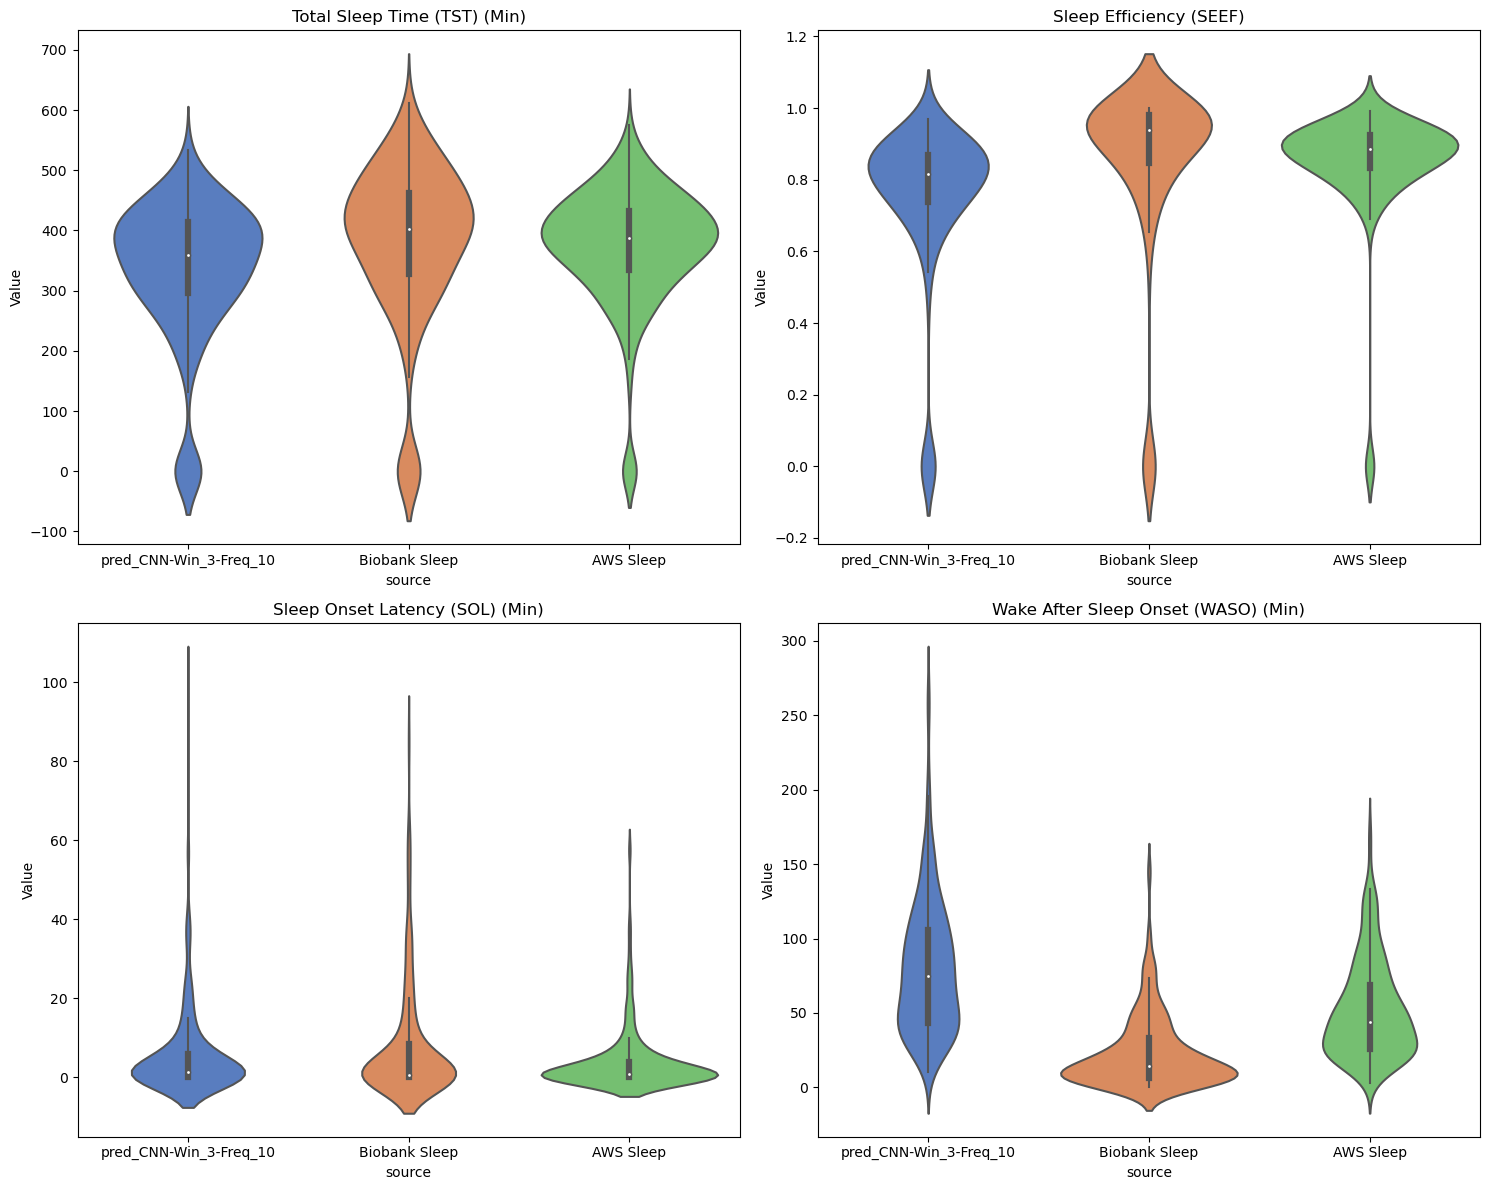

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt


# Filter out columns for plotting
columns_to_keep = ['source', 'TST (Min)', 'SEEF', 'SOL (Min)', 'WASO (Min)']
plot_df = metrics_df[columns_to_keep]

# Melt the dataframe for seaborn plotting
plot_df_melted = pd.melt(plot_df, id_vars=['source'], var_name='Metric', value_name='Value')

# Define function to create violin plots
def create_violin_plots():
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: TST (Min)
    sns.violinplot(x='source', y='Value', data=plot_df_melted[plot_df_melted['Metric'] == 'TST (Min)'], ax=axs[0, 0], palette="muted")
    axs[0, 0].set_title('Total Sleep Time (TST) (Min)')

    # Plot 2: SEEF
    sns.violinplot(x='source', y='Value', data=plot_df_melted[plot_df_melted['Metric'] == 'SEEF'], ax=axs[0, 1], palette="muted")
    axs[0, 1].set_title('Sleep Efficiency (SEEF)')

    # Plot 3: SOL (Min)
    sns.violinplot(x='source', y='Value', data=plot_df_melted[plot_df_melted['Metric'] == 'SOL (Min)'], ax=axs[1, 0], palette="muted")
    axs[1, 0].set_title('Sleep Onset Latency (SOL) (Min)')

    # Plot 4: WASO (Min)
    sns.violinplot(x='source', y='Value', data=plot_df_melted[plot_df_melted['Metric'] == 'WASO (Min)'], ax=axs[1, 1], palette="muted")
    axs[1, 1].set_title('Wake After Sleep Onset (WASO) (Min)')

    plt.tight_layout()
    plt.show()

# Create the violin plots
create_violin_plots()


In [55]:
# Confusion matrix


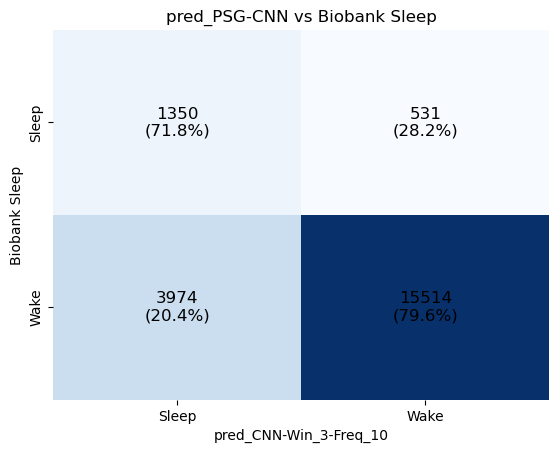

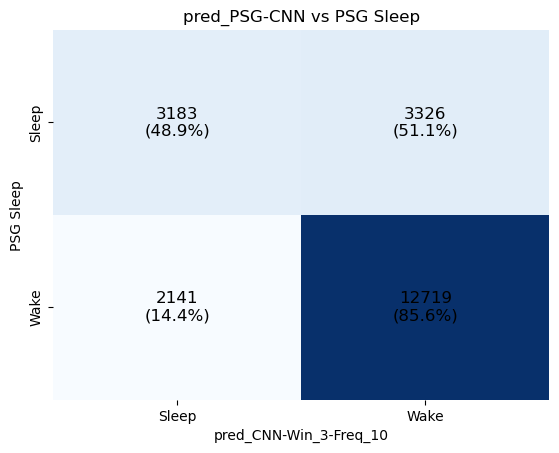

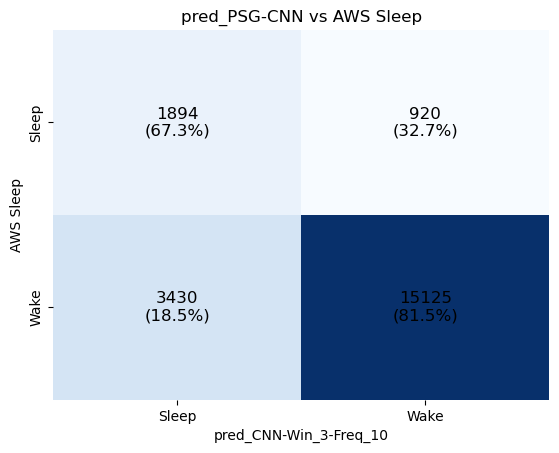

In [59]:
from sklearn.metrics import confusion_matrix
import os 

# Directory containing the CSV files
directory_path = 'Results/merged_indicators'

# List all CSV files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Load and concatenate all CSV files
data_list = [pd.read_csv(os.path.join(directory_path, file)) for file in csv_files]
data = pd.concat(data_list, ignore_index=True)

# Drop rows with NaN values to clean the data for analysis
cleaned_data = data.dropna(subset=[pred_col_name, 'Biobank Sleep', 'PSG Sleep', 'AWS Sleep'])

# Create a function to calculate and return confusion matrix and percentages
def create_confusion_matrix(df, true_label, pred_label):
    cm = confusion_matrix(df[true_label], df[pred_label], labels=[0, 1])
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    return cm, cm_percent

# Calculate confusion matrices and percentages
cm_biobank, cm_biobank_percent = create_confusion_matrix(cleaned_data, 'Biobank Sleep', pred_col_name)
cm_psg, cm_psg_percent = create_confusion_matrix(cleaned_data, 'PSG Sleep', pred_col_name)
cm_aws, cm_aws_percent = create_confusion_matrix(cleaned_data, 'AWS Sleep', pred_col_name)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, cm_percent, title, x_label,y_label):
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax, cbar=False)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j+0.5, i+0.5, f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)', 
                    horizontalalignment='center', verticalalignment='center', color='black', fontsize=12)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticklabels(['Sleep', 'Wake'])
    ax.set_yticklabels(['Sleep', 'Wake'])
    ax.set_title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(cm_biobank, cm_biobank_percent, 'pred_PSG-CNN vs Biobank Sleep',pred_col_name , 'Biobank Sleep')
plot_confusion_matrix(cm_psg, cm_psg_percent, 'pred_PSG-CNN vs PSG Sleep', pred_col_name,'PSG Sleep')
plot_confusion_matrix(cm_aws, cm_aws_percent, 'pred_PSG-CNN vs AWS Sleep',pred_col_name,'AWS Sleep')


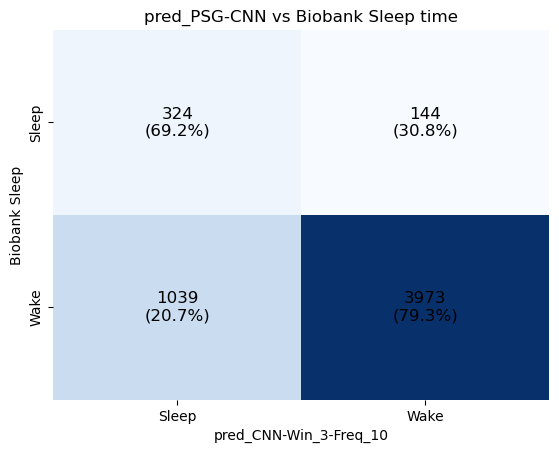

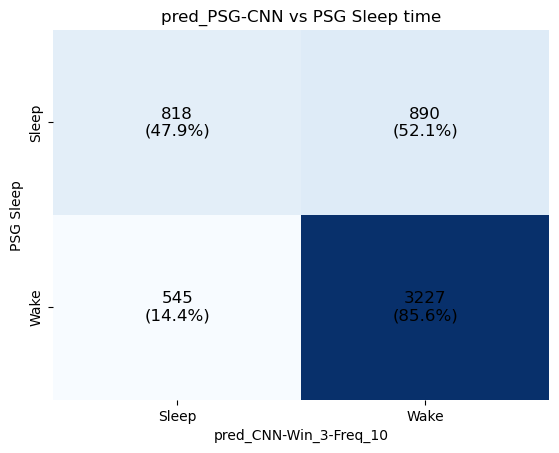

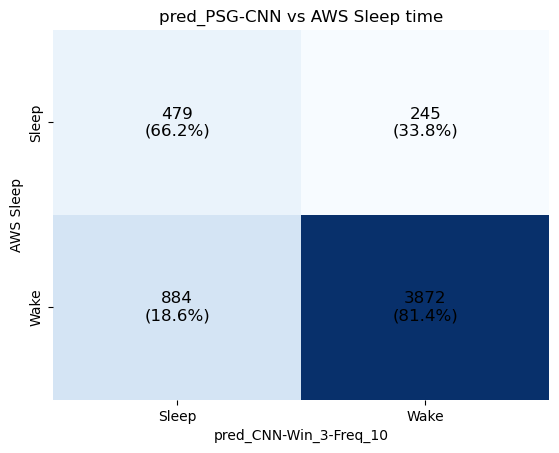

In [58]:
## sleep time confusion matrix

from datetime import datetime


# Function to parse marker file and extract sleep duration
def get_sleep_duration(marker_file):
    with open(marker_file, 'r') as file:
        lines = file.readlines()
        
    lights_off_time = None
    lights_on_time = None
    
    for line in lines:
        if 'Lights Off' in line:
            lights_off_time = datetime.strptime(line.split(',')[0], '%d.%m.%Y %H:%M:%S')
        elif 'Lights On' in line:
            lights_on_time = datetime.strptime(line.split(',')[0], '%d.%m.%Y %H:%M:%S')
    
    if lights_off_time and lights_on_time:
        return (lights_on_time - lights_off_time).total_seconds() / 3600.0  # Return duration in hours
    else:
        return None

# Directory containing the CSV files and marker files
csv_directory_path = 'Results/merged_indicators'  
marker_directory_path = 'data/PSG markers'  

# List all CSV and marker files in the directories
csv_files = sorted([file for file in os.listdir(csv_directory_path) if file.endswith('.csv')])
marker_files = sorted([file for file in os.listdir(marker_directory_path) if file.endswith('.txt')])

# Load and concatenate all CSV files
data_list = [pd.read_csv(os.path.join(csv_directory_path, file)) for file in csv_files]
data = pd.concat(data_list, ignore_index=True)

# Extract sleep durations from marker files
sleep_durations = []
for marker_file in marker_files:
    duration = get_sleep_duration(os.path.join(marker_directory_path, marker_file))
    sleep_durations.append(duration)

# Check if the number of sleep durations matches the expected length
expected_length = len(data)
actual_length = len(sleep_durations) * (expected_length // len(sleep_durations))



# Adjust the length of sleep durations to match the data length
if len(sleep_durations) > 0:
    repetitions = (len(data) // len(sleep_durations)) + 1
    sleep_durations = np.tile(sleep_durations, repetitions)[:len(data)]

# Add sleep durations to the data
data['Sleep Duration'] = sleep_durations

# Drop rows with NaN values to clean the data for analysis
cleaned_data = data.dropna(subset=[pred_col_name, 'Biobank Sleep', 'PSG Sleep', 'AWS Sleep', 'Sleep Duration'])

# Create a function to calculate and return confusion matrix and percentages
def create_confusion_matrix(df, true_label, pred_label):
    cm = confusion_matrix(df[true_label], df[pred_label], labels=[0, 1])
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    return cm, cm_percent

# Calculate confusion matrices and percentages
cm_biobank, cm_biobank_percent = create_confusion_matrix(cleaned_data, 'Biobank Sleep', pred_col_name)
cm_psg, cm_psg_percent = create_confusion_matrix(cleaned_data, 'PSG Sleep', pred_col_name)
cm_aws, cm_aws_percent = create_confusion_matrix(cleaned_data, 'AWS Sleep', pred_col_name)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, cm_percent, title,x_label, y_label):
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax, cbar=False)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j+0.5, i+0.5, f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)', 
                    horizontalalignment='center', verticalalignment='center', color='black', fontsize=12)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticklabels(['Sleep', 'Wake'])
    ax.set_yticklabels(['Sleep', 'Wake'])
    ax.set_title(title)
    plt.show()


# Plot confusion matrices
plot_confusion_matrix(cm_biobank, cm_biobank_percent, 'pred_PSG-CNN vs Biobank Sleep time',pred_col_name , 'Biobank Sleep')
plot_confusion_matrix(cm_psg, cm_psg_percent, 'pred_PSG-CNN vs PSG Sleep time', pred_col_name,'PSG Sleep')
plot_confusion_matrix(cm_aws, cm_aws_percent, 'pred_PSG-CNN vs AWS Sleep time',pred_col_name,'AWS Sleep')

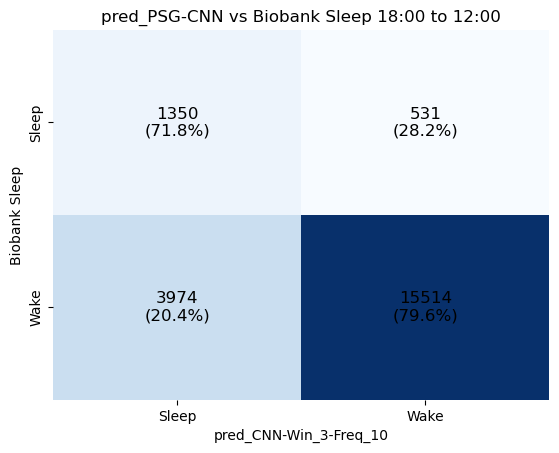

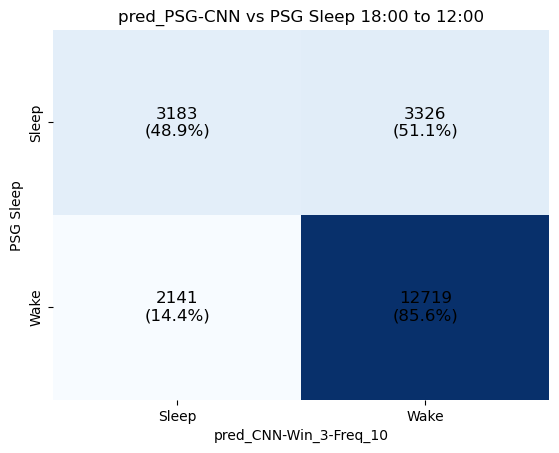

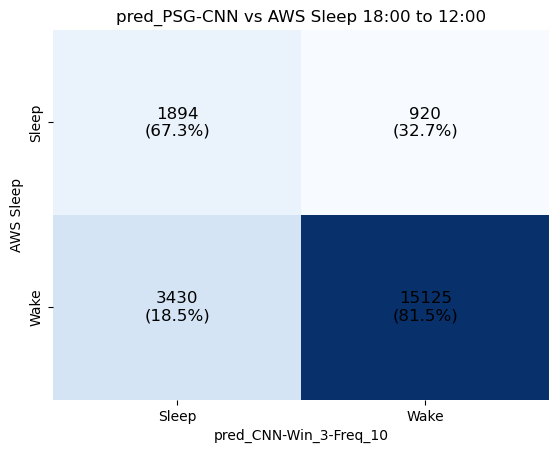

In [61]:
## 18:00 to 12:00 confusion matrix

# Directory containing the CSV files
directory_path = 'Results/merged_indicators'

# List all CSV files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Load and concatenate all CSV files
data_list = [pd.read_csv(os.path.join(directory_path, file)) for file in csv_files]
data = pd.concat(data_list, ignore_index=True)

# Convert the 'epoch_ts' column to datetime format
data['epoch_ts'] = pd.to_datetime(data['epoch_ts'])

# Define the start and end date for the entire dataset
data['date'] = data['epoch_ts'].dt.date
start_date = data['date'].min()
end_date = data['date'].max()

# Function to create confusion matrix
def create_confusion_matrix(df, true_label, pred_label):
    cm = confusion_matrix(df[true_label], df[pred_label], labels=[0, 1])
    return cm

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title,x_label, y_label):
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax, cbar=False)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j + 0.5, i + 0.5, f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)',
                    horizontalalignment='center', verticalalignment='center', color='black', fontsize=12)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticklabels(['Sleep', 'Wake'])
    ax.set_yticklabels(['Sleep', 'Wake'])
    ax.set_title(title)
    plt.show()

# Initialize cumulative confusion matrices
cumulative_cm_biobank = np.zeros((2, 2), dtype=int)
cumulative_cm_psg = np.zeros((2, 2), dtype=int)
cumulative_cm_aws = np.zeros((2, 2), dtype=int)

# Iterate through each day in the range and calculate confusion matrices
for single_date in pd.date_range(start=start_date, end=end_date):
    start_time = f'{single_date} 18:00:00'
    end_time = f'{single_date + pd.Timedelta(days=1)} 12:00:00'
    
    filtered_data = data[(data['epoch_ts'] >= start_time) & (data['epoch_ts'] <= end_time)]
    cleaned_data = filtered_data.dropna(subset=[pred_col_name, 'Biobank Sleep', 'PSG Sleep', 'AWS Sleep'])
    
    if not cleaned_data.empty:
        cm_biobank = create_confusion_matrix(cleaned_data, 'Biobank Sleep', pred_col_name)
        cm_psg = create_confusion_matrix(cleaned_data, 'PSG Sleep', pred_col_name)
        cm_aws = create_confusion_matrix(cleaned_data, 'AWS Sleep', pred_col_name)
        
        cumulative_cm_biobank += cm_biobank
        cumulative_cm_psg += cm_psg
        cumulative_cm_aws += cm_aws


# Plot confusion matrices
plot_confusion_matrix(cumulative_cm_biobank, 'pred_PSG-CNN vs Biobank Sleep 18:00 to 12:00',pred_col_name , 'Biobank Sleep')
plot_confusion_matrix(cumulative_cm_psg, 'pred_PSG-CNN vs PSG Sleep 18:00 to 12:00', pred_col_name,'PSG Sleep')
plot_confusion_matrix(cumulative_cm_aws, 'pred_PSG-CNN vs AWS Sleep 18:00 to 12:00',pred_col_name,'AWS Sleep')
